In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, UnivariateSpline, LSQUnivariateSpline
import scipy.optimize as opt
import scipy.special as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pysindy as ps

# Генерация данных

## Функция для вычисления приращений концентраций веществ

In [2]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [33]:
N_REACTION = 4                                                           # кол-во реакций
N_SUBSTANCE = 5                                                          # кол-во веществ
VR_TIME = 40                                                             # время протекания реакций
# INIT_CONC = np.array([1.0, 0.5, 0.1, 0.4, 0])                            # начальные концентрации веществ
# k = np.array([0.2, 0.1, 0.13, 0.3])                                      # константы скоростей реакций

k = np.array([0.02, 0.5, 0.05, 2.])
INIT_CONC = np.array([4.0, 1, 0, 0, 0])

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(0, VR_TIME, VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

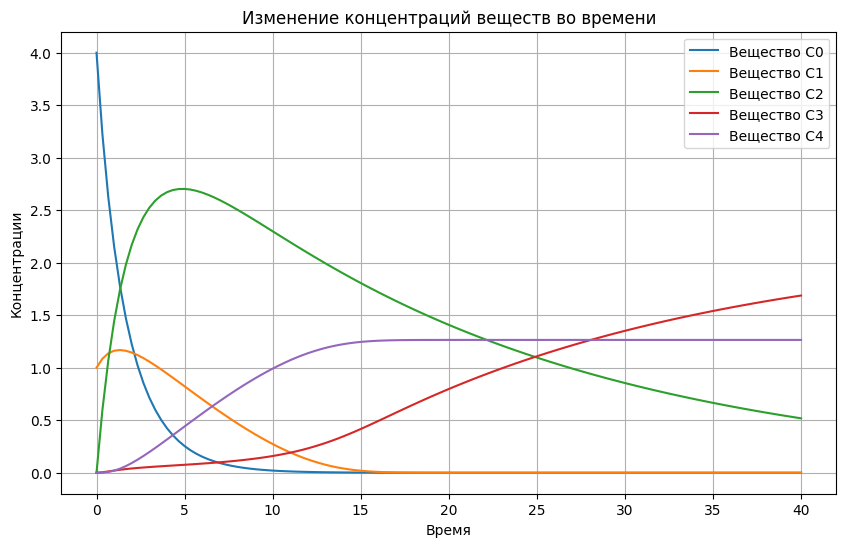

In [53]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid()
plt.show()

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Добавление шума

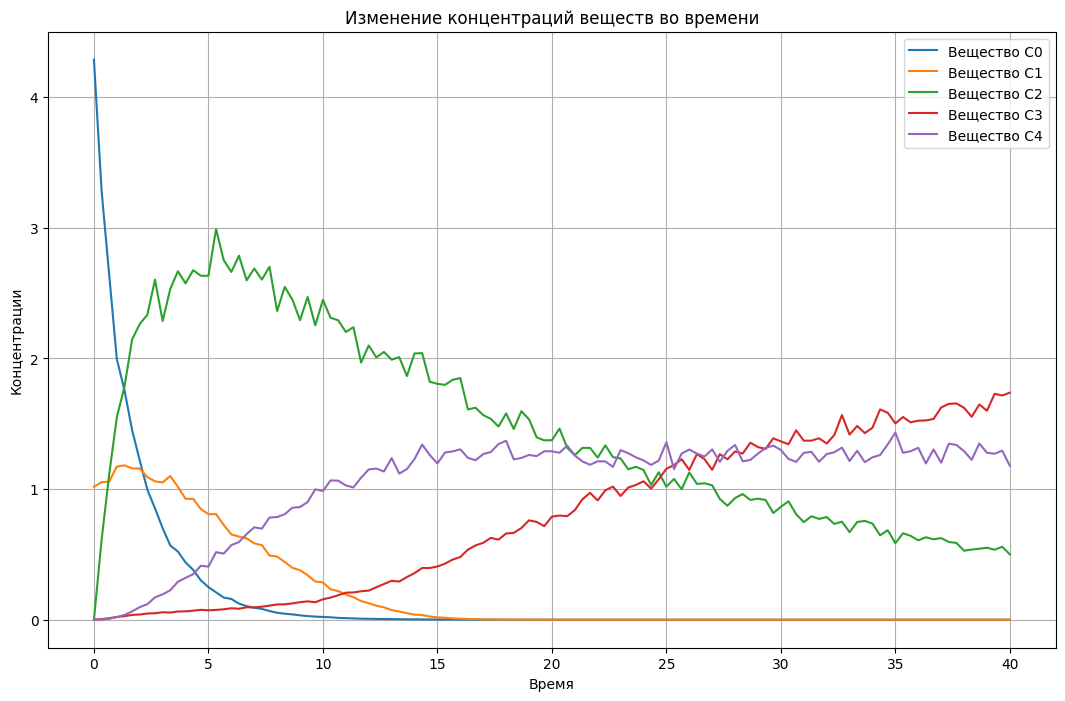

In [54]:
# Генерация шума
noise_level = 4e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
np.random.seed(3)

noise = np.random.normal(0, noise_level * np.abs(y_noisy))          #  это шум
y_noisy += noise                                                    #  это шум

# Построение графиков
plt.figure(figsize=(13, 8))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество C{i}')
    # plt.plot(sol.t, sol.y[i])

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


### Сохранение данных в нужном формате

In [55]:
data = pd.DataFrame(y_noisy.T)
# df.to_csv("generate_concentrations_1.csv", index=False)
print(data)

                0             1         2         3         4
0    4.286181e+00  1.017057e+00  0.000000  0.000000  0.000000
1    3.283731e+00  1.052818e+00  0.609570  0.004138  0.000973
2    2.637903e+00  1.057158e+00  1.113310  0.012022  0.007267
3    1.994192e+00  1.172301e+00  1.550800  0.020976  0.020547
4    1.757263e+00  1.181865e+00  1.783479  0.027531  0.036320
..            ...           ...       ...       ...       ...
116  1.262850e-08  6.207074e-07  0.543366  1.647373  1.349146
117  1.053867e-08 -5.754582e-07  0.551223  1.599553  1.277899
118  8.458724e-09  1.221152e-06  0.535616  1.728837  1.270337
119  7.805864e-09  5.820559e-07  0.558528  1.716188  1.294080
120  6.100092e-09  2.582513e-07  0.500151  1.737946  1.178132

[121 rows x 5 columns]


# Построение аппроксимации

## Сплайнами

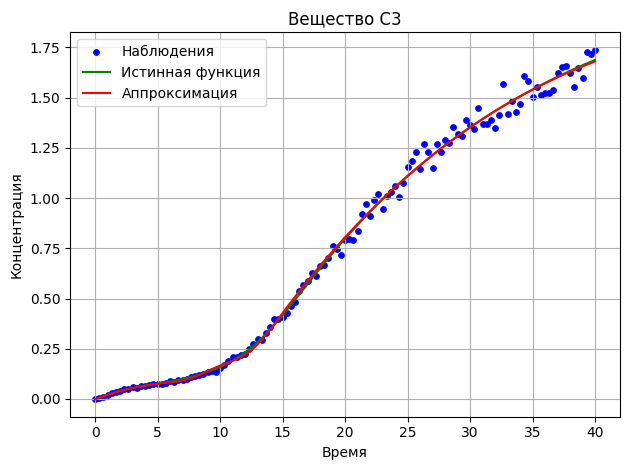

In [63]:
splines_data = np.zeros_like(data[0])    # Массив для хранения данных генерации моделей
splines_model = []                       # Массив для хранения моделей

# Создаем плотную сетку для отображения сплайна
x_dense = np.linspace(0, VR_TIME, len(tsteps) * 1)

# Явное задание узлов разбиения
knots = np.linspace(0, VR_TIME, 7)          
knots = np.delete(knots, [0, -1])           # Узлы должны быть внутри диапазона x, не должны содержать концов

# knots_smart = [10.]                # Сделал меньше промежутки в начале, где происходят интенсивные изменения
knots_smart = [5., 7.5, 10., 12.5, 15.]

# Перебираем вещества
for i in [3]:
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline = LSQUnivariateSpline(tsteps, y, knots_smart, k=3)
    splines_model.append(spline)  # Сохраняем модель

    y_pred = spline(x_dense)
    splines_data = y_pred  # Сохраняем данные модели

    # Строим график
    plt.scatter(tsteps, y, color='blue', label='Наблюдения', s=15)
    plt.plot(tsteps, CONC_TRUE[i], color='green', label='Истинная функция')
    plt.plot(x_dense, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    plt.title(f'Вещество C{i}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Вывод коэффициентов
    # r2 = r2_score(CONC_TRUE[i], y_pred)
    # print(f"Вещество C{i}: R^2 = {r2:.6f}")


## Функцией Гамма-распределения

В данной вариации гамма-функцией будут аппроксимироваться 0,1,2 и 4 вещества. 3-е вещество аппроксимируется полиномом

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_21872\1864944776.py:2: RuntimeWarning:

divide by zero encountered in power

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_21872\1864944776.py:5: RuntimeWarning:

divide by zero encountered in reciprocal

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_21872\1864944776.py:5: RuntimeWarning:

invalid value encountered in multiply

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_21872\1864944776.py:5: RuntimeWarning:

divide by zero encountered in power



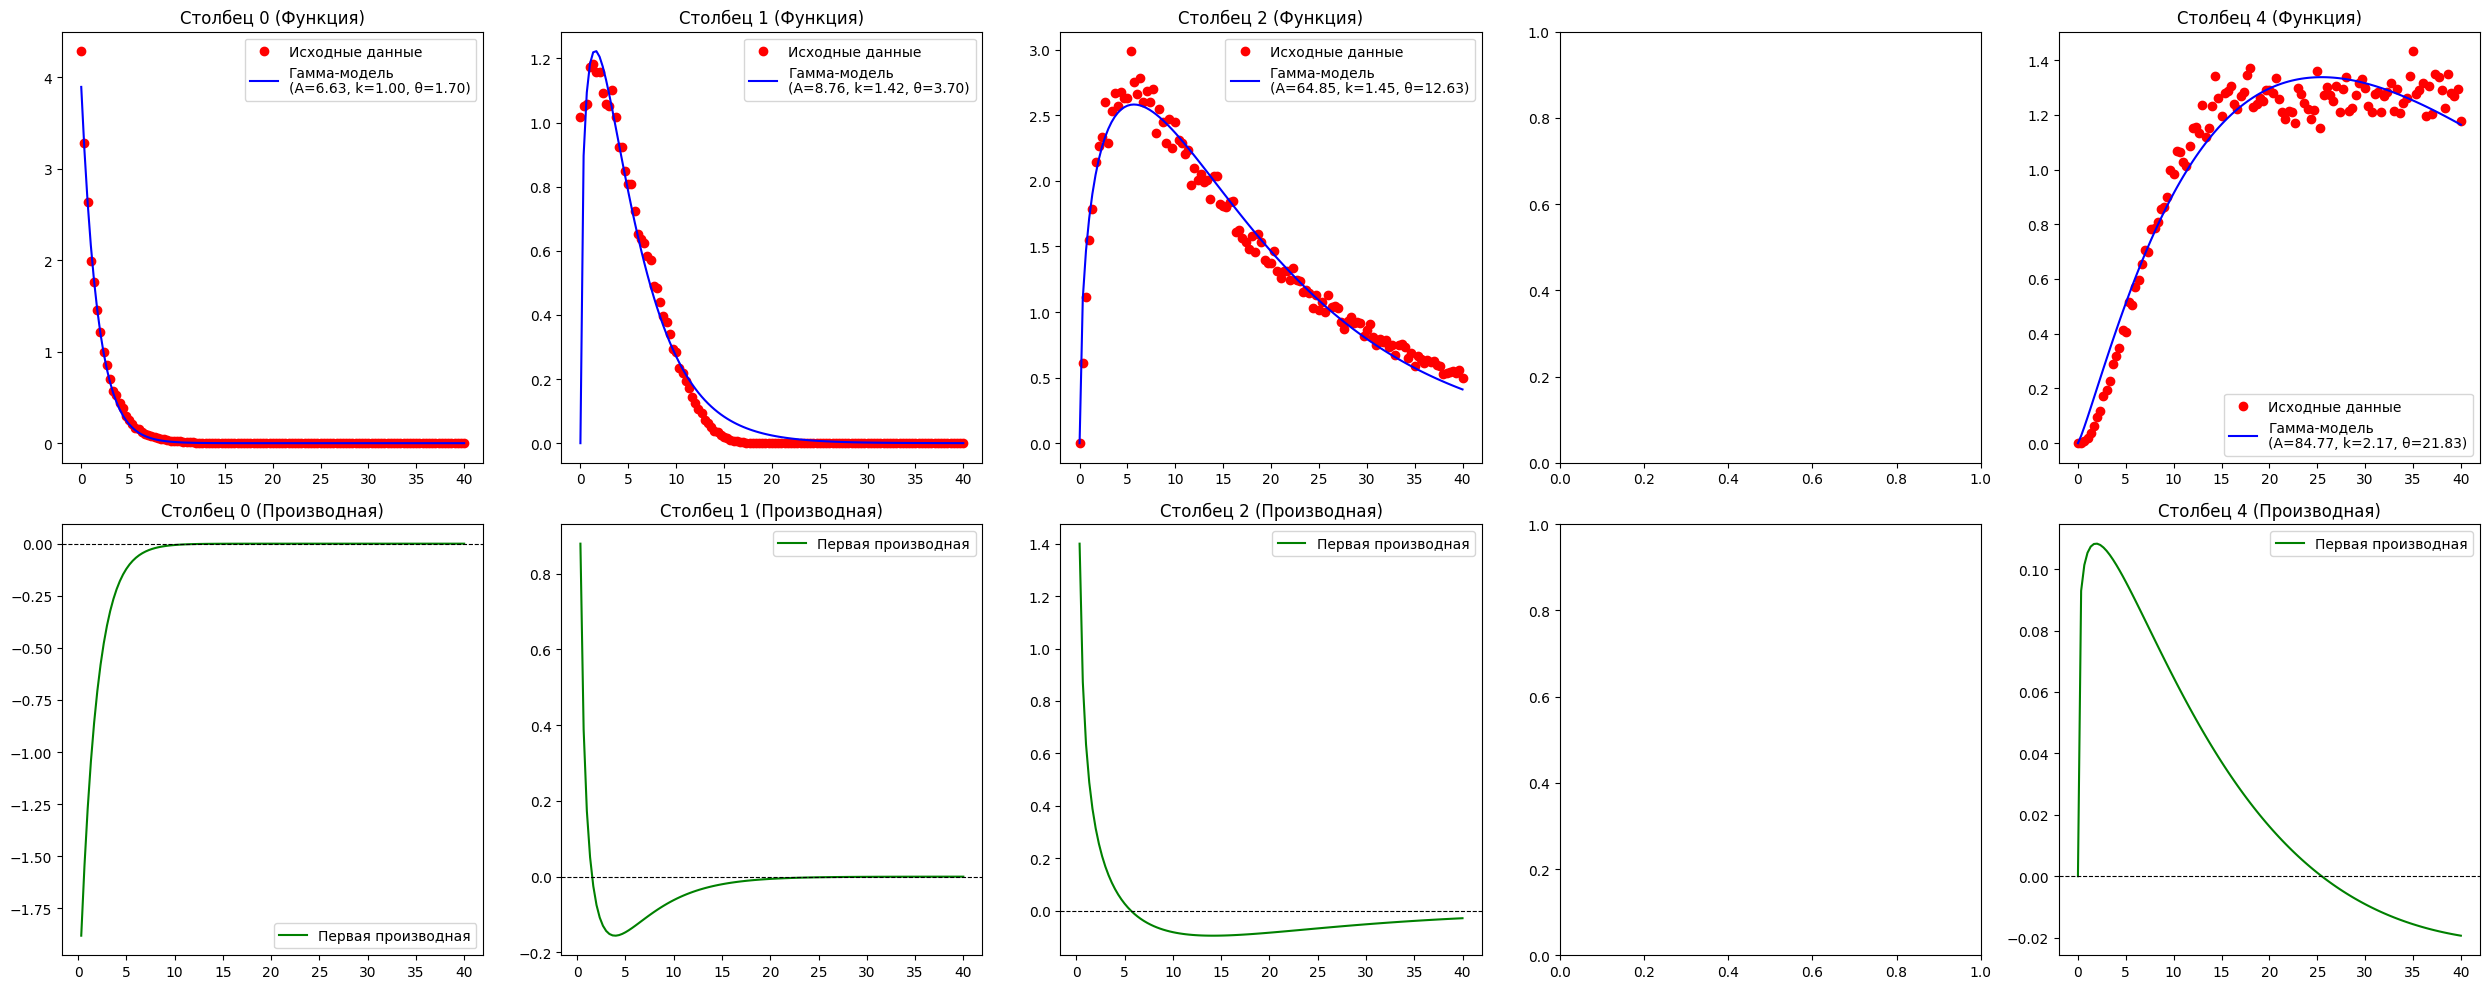

0: A=6.63345, k=1.00000, θ=1.70285
1: A=8.76227, k=1.41697, θ=3.69511
2: A=64.85342, k=1.44934, θ=12.62824
4: A=84.76923, k=2.16624, θ=21.83197


In [64]:
def gamma_function(t, A, k, theta):
    return A * (t ** (k - 1)) * np.exp(-t / theta) / (theta ** k * sp.gamma(k))

def gamma_derivative(t, A, k, theta):
    term1 = (k - 1) * t ** (k - 2) * np.exp(-t / theta)
    term2 = t ** (k - 1) * np.exp(-t / theta) / theta
    return A * (term1 - term2) / (theta ** k * sp.gamma(k))

num_columns = data.shape[1]

# Создание графиков для каждого столбца
fig, axes = plt.subplots(2, num_columns, figsize=(5 * num_columns, 10))
if num_columns == 1:
    axes = [axes]

# np массивы для хранения данных
data_common = np.zeros_like(data)               # хранение концентраций
derivatives_common = np.zeros_like(data)        # хранение производных

for i in [0, 1, 2, 4]:
    column_data = data[i]
    
    # Подбор параметров функции изменения во времени
    params, _ = opt.curve_fit(gamma_function, tsteps[:len(column_data)], column_data, p0=[1, 2, 1])
    A_opt, k_opt, theta_opt = params
    if (k_opt - 1) < 0.01:
        k_opt = 1
    
    # Вычисление функции и её производной
    fit_curve = gamma_function(tsteps, A_opt, k_opt, theta_opt)
    fit_derivative = gamma_derivative(tsteps, A_opt, k_opt, theta_opt)

    # Сохраняем результаты в словари
    data_common[:, i] = fit_curve
    derivatives_common[:, i] = fit_derivative
    
    # Визуализация функции
    axes[0, i].scatter(tsteps, column_data, label='Исходные данные', color='red')
    axes[0, i].plot(tsteps, fit_curve, label=f'Гамма-модель\n(A={A_opt:.2f}, k={k_opt:.2f}, θ={theta_opt:.2f})', color='blue')
    axes[0, i].set_title(f'Столбец {i} (Функция)')
    axes[0, i].legend()
    
    # Визуализация производной
    axes[1, i].plot(tsteps, fit_derivative, label='Первая производная', color='green')
    axes[1, i].set_title(f'Столбец {i} (Производная)')
    axes[1, i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[1, i].legend()

plt.tight_layout()
plt.show()


# Вывод оптимальных параметров для всех столбцов
for column in [0, 1, 2, 4]:
    column_data = data[column]
    params, _ = opt.curve_fit(gamma_function, tsteps[:len(column_data)], column_data, p0=[1, 2, 1])
    A_opt, k_opt, theta_opt = params
    print(f"{column}: A={A_opt:.5f}, k={k_opt:.5f}, θ={theta_opt:.5f}")

### Объединение концентраций по полиномам и Гамма-распределению

In [65]:
data_common[:,3] = splines_data

# Производные

### Оригинал 

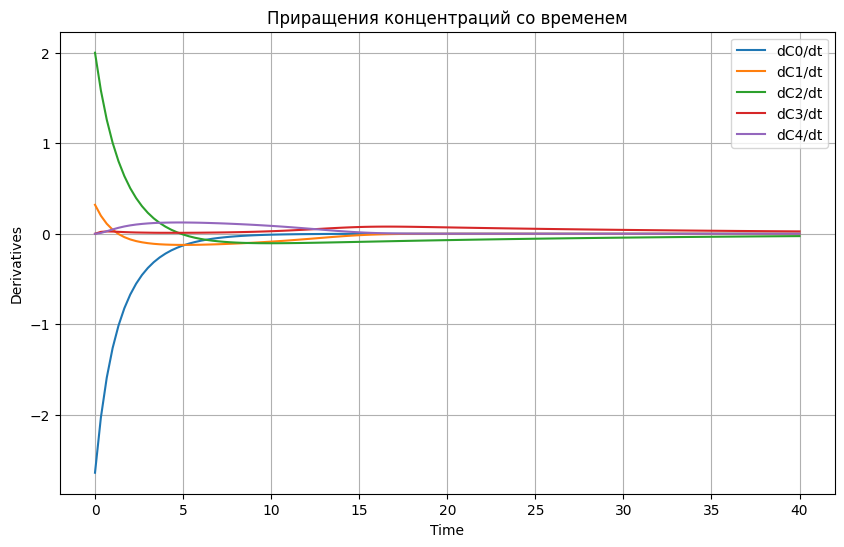

In [66]:
dCdt_TRUE = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # Приращения по истинным концентрациям C

plt.figure(figsize=(10, 6))
for i in range(dCdt_TRUE.shape[0]):
    plt.plot(sol.t, dCdt_TRUE[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

## Производные для сплайнов через ЧМ

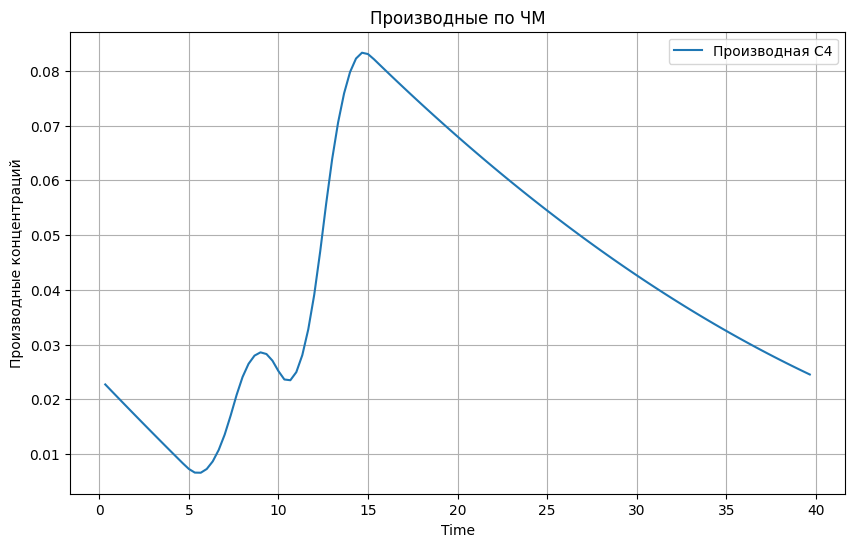

In [67]:
# Построение графиков
plt.figure(figsize=(10, 6))

h = tsteps[1] - tsteps[0]
dCdt_NM = np.zeros_like(dCdt_TRUE[0])

spl = splines_model[0]
dCdt_NM[1:-1] = (spl(tsteps[2:]) - spl(tsteps[:-2])) / (2 * h)    # центральная разность
dCdt_NM[0] = (spl(tsteps[1]) - spl(tsteps[0])) / h                # левая разность
dCdt_NM[-1] = (spl(tsteps[-1]) - spl(tsteps[-2])) / h             # правая разность

# Вывод на график
plt.plot(tsteps[1:-1], dCdt_NM[1:-1], label=f'Производная C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные по ЧМ')
plt.legend()
plt.grid()
plt.show()

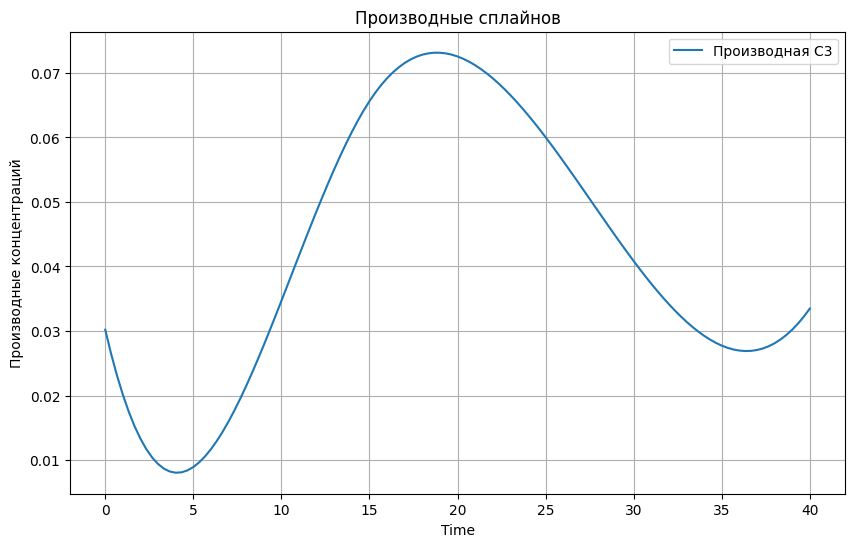

In [68]:
splines_NM = []
knots = [10, 15]

# Создаем и обучаем модель полиномиальной регрессии
splines_NM = LSQUnivariateSpline(tsteps, dCdt_NM, knots, k=3)
y_pred = splines_NM(tsteps)

dCdt_spline_NM = np.zeros_like(dCdt_TRUE[0])         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))
dCdt_spline_NM = y_pred
plt.plot(tsteps, dCdt_spline_NM, label=f'Производная C3')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные сплайнов')
plt.legend()
plt.grid()
plt.show()

In [69]:
derivatives_common_1 = derivatives_common.copy()
derivatives_common_2 = derivatives_common.copy()

derivatives_common_1[:, 3] = dCdt_NM
derivatives_common_2[:, 3] = dCdt_spline_NM

# Вычисление k

In [70]:
K_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # k по изначальным данным
k_g_spline = np.zeros((N_REACTION, len(tsteps)))                        # k по полиномам
k_g_spline_NM = np.zeros((N_REACTION, len(tsteps)))                      # k по сплайнам


W_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # W(скорости реакций) по изначальным данным
W_g_spline = np.zeros((N_REACTION, len(tsteps)))                        # W по полиномам
W_g_spline_NM = np.zeros((N_REACTION, len(tsteps)))                      # W по сплайнам


C_TRUE = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C(концентрации) по изначальным данным
C_g_spline = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C по полиномам
C_g_spline_NM = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C по сплайнам


### Чтобы не забывать

In [71]:
data_common                 # концентрации
derivatives_common_1        # производные по G + по чм
derivatives_common_2        # производные по G + сглаженные

array([[            nan,             inf,             inf,
         3.02056432e-02,  0.00000000e+00],
       [-1.88093017e+00,  8.78762381e-01,  1.39956101e+00,
         2.64623311e-02,  9.29594438e-02],
       [-1.54653395e+00,  3.88044785e-01,  8.72522547e-01,
         2.31062063e-02,  1.01369218e-01],
       [-1.27158749e+00,  1.73174597e-01,  6.34499880e-01,
         2.01245443e-02,  1.05358703e-01],
       [-1.04552165e+00,  5.13239696e-02,  4.89823819e-01,
         1.75046208e-02,  1.07361978e-01],
       [-8.59646341e-01, -2.49943587e-02,  3.89506116e-01,
         1.52337112e-02,  1.08215186e-01],
       [-7.06816381e-01, -7.49002589e-02,  3.14583835e-01,
         1.32990911e-02,  1.08316211e-01],
       [-5.81156893e-01, -1.07962422e-01,  2.55921403e-01,
         1.16880360e-02,  1.07889004e-01],
       [-4.77837445e-01, -1.29642297e-01,  2.08479487e-01,
         1.03878213e-02,  1.07073509e-01],
       [-3.92886374e-01, -1.43340861e-01,  1.69207284e-01,
         9.38572270e-03

In [72]:
matrix_transformations = np.linalg.inv(MATR @ MATR.T) @ MATR
print(matrix_transformations)

[[-0.3125  0.375  -0.3125 -0.3125  0.0625]
 [-0.3125 -0.625   0.6875  0.6875  0.0625]
 [-0.25   -0.5    -0.25    0.75    0.25  ]
 [-0.1875 -0.375  -0.1875 -0.1875  0.4375]]


### k по начальным данным

In [73]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_TRUE.T[i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_TRUE[:, i] = W
    C_TRUE[:, i] = C
    K_TRUE[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

# print(k_eval)


C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_21872\2113065020.py:10: RuntimeWarning:

divide by zero encountered in divide



### k по G + сплайнам

In [74]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps[1:]):
    W = matrix_transformations @ derivatives_common_1[i]
    C = data_common[i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_g_spline[:, i] = W
    C_g_spline[:, i] = C
    k_g_spline[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)

### k по G + сплайнам с ЧМ производными 

In [75]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps[1:]):
    W = matrix_transformations @ derivatives_common_2[i]
    C = data_common[i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_g_spline_NM[:, i] = W
    C_g_spline_NM[:, i] = C
    k_g_spline_NM[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)

## Генерация k в ходе обратной задачи 

In [76]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Orig', 'Spline'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=K_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_g_spline[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [77]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Orig', 'Spline_NM'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_g_spline[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_g_spline_NM[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [52]:
mean_spline = np.round(np.mean(k_g_spline[:, 1:60], axis=1), 3)
print('Средние k по Spline:       ', *mean_spline)
median_spline = np.round(np.median(k_g_spline[:, 1:60], axis=1), 3)
print('Медианные k по Spline:     ', *median_spline)

print()

mean_spline_NM = np.round(np.mean(k_g_spline_NM[:, 1:60], axis=1), 3)
print('Средние k по Spline_NM:     ', *mean_spline_NM)
median_spline_NM = np.round(np.median(k_g_spline_NM[:, 1:60], axis=1), 3)
print('Медианные k по Spline_NM:   ', *median_spline_NM)

print()
print('k = ', k)

Средние k по Spline:        177361.231 -20.572 0.043 1.747
Медианные k по Spline:      0.064 0.407 0.046 1.081

Средние k по Spline_NM:      176900.613 -20.522 0.043 1.747
Медианные k по Spline_NM:    0.064 0.407 0.046 1.081

k =  [0.02 0.5  0.05 2.  ]


# W - скорости реакций

In [25]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-orig', 'W-spline'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_g_spline[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='W-скорость реакции', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='W-скорость реакции', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


W-скорости реакций предсказываются отрицательными. Они не должны быть отрицательными

In [26]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-spline', 'W-spline_NM'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_g_spline[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_g_spline_NM[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='W-скорость реакции', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='W-скорость реакции', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()
